# Phase 2: Data Augmentation

**In this notebook, I will take the most efficient model created from Phase 1, and attempt to improve upon the model´s performance with the Cifar-10 dataset.**


The goal of this notebook is to build upon the most effective model from Phase 1, focussing on:

- Optimum Data Augmentation techniques to build upon the model's accuracy

For more information, please go to https://www.cs.toronto.edu/~kriz/cifar.html

---

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from keras.layers import Conv2D, Flatten

import time
starting_time = time.time()

## Read Data

**The following steps have been covered in *Phase 1* of the project. For more information on how the data was extracted and pre-processed, please refer to the Phase 1 notebook**

In [2]:
#define the unpickle function provided by the readme.html file with the data

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Pre-Processing
### Creating a Function, Unpickling and Preparing The Data

In [3]:
def preparecifar10(batches):
    _data = []
    _labels = []
    
    # Load and concatenate all batches
    for batch in batches:
        data = batch[b'data']
        labels = batch[b'labels']

        #put data in array format
        data = np.array(data, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)

        #reshape the data to combine RGB elements in one image
        images = data.reshape(-1, 3, 32, 32)
        images = np.swapaxes(images, 1, 3)

        #normalise the data to fit between 0 and 1, then rotate, then resize and rescale
        images = images / 255.0
        images = tf.image.rot90(images,3)
        _data.append(images)
        _labels.append(labels)
    
    # Convert lists to numpy arrays
    _data = np.concatenate(_data, axis=0)
    _labels = np.concatenate(_labels, axis=0)

    return _data, _labels


In [4]:
#unpickle train data
batches = [unpickle(f'data/cifar-10-batches-py/data_batch_{i}') for i in range(1, 6)]

#unpickle test data
tests = [unpickle(f'data/cifar-10-batches-py/test_batch')]

### Apply the function to prepare the data. 

In [5]:
train_images, train_labels = preparecifar10(batches)
test_images, test_labels = preparecifar10(tests)

## Metadata Unpickle

In [6]:
#load the metadata
metadata = unpickle('data/cifar-10-batches-py/batches.meta')

In [7]:
metadata[b'label_names']
clean = []
for i in metadata[b'label_names']:
    clean.append(str(i).split("'")[1])

In [8]:
#Create a dictionary with each label and number equivalent
labeldict = []
for i in range(len(np.unique(train_labels))):
    labeldict.append({np.unique(train_labels)[i]:metadata[b'label_names'][i]})
    

In [9]:
classnames = dict(zip(np.unique(train_labels),clean))

 ---

## Augmentation

**Data Augmentation can take different forms. The general idea is to use the data that we have to give the machine learning model as much of a chance as possible to detect the various shapes in the images. This can take the following forms:**

- Resizing and Rescaling Images
- Flipping and Rotating
- Greyscaling
- Saturating
- Zooming
- Translating

**These techniques will be demonstrated in this segment**


### Augmentation Methods

#### Resize and Rescale

In [10]:
IMG_SIZE = 250
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1) #
])

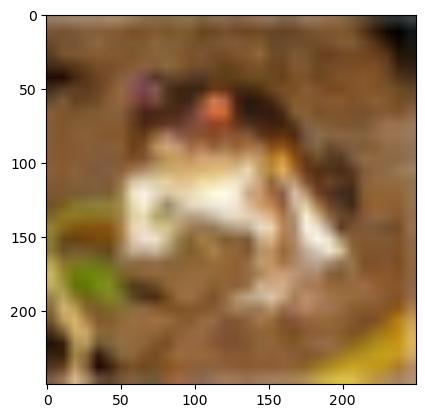

In [11]:
plt.imshow(resize_and_rescale(train_images[0]));

#### Flip and Rotate Images

In [12]:
flip_rotate = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),])

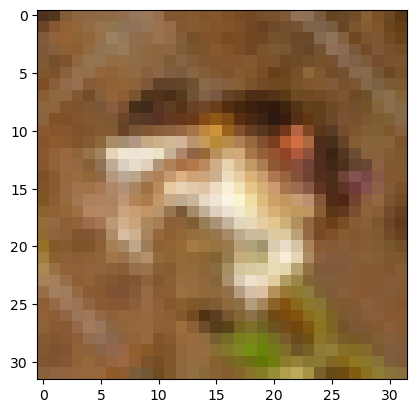

In [13]:
plt.imshow(flip_rotate(train_images[0]));

#### Greyscale Images

In [14]:
grayscaled = tf.image.rgb_to_grayscale(train_images)

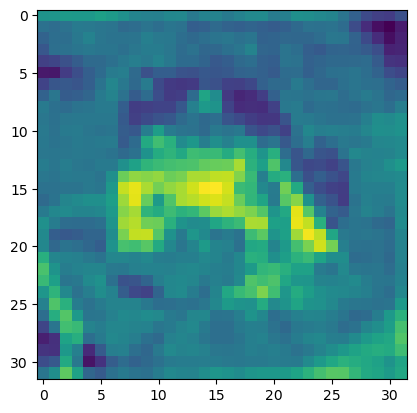

In [15]:
plt.imshow(grayscaled[0]);

#### Apply Random Zoom To Images

In [16]:
random_zoom = tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)

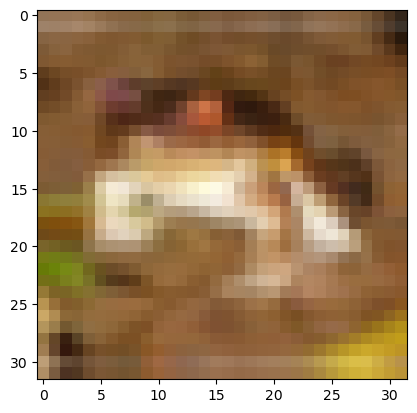

In [17]:
plt.imshow(random_zoom(train_images[0]));

#### Apply Random Flip to Images

In [18]:
random_flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")

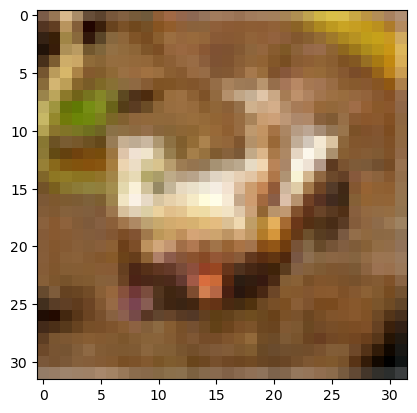

In [19]:
plt.imshow(random_flip(train_images[0]));

#### Apply Random Rotation to Images

In [20]:
random_rotation = tf.keras.layers.RandomRotation(0.2)

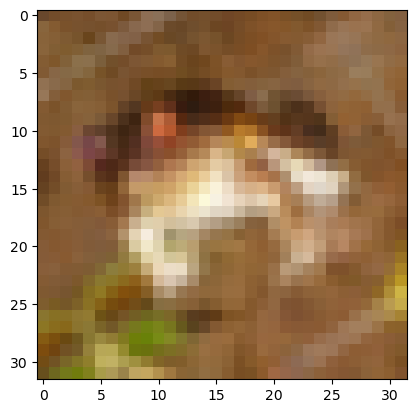

In [21]:
plt.imshow(random_rotation(train_images[0]));

#### Apply Random Translation to Images

In [22]:
random_translation = tf.keras.layers.RandomTranslation(0.2, 0.2)

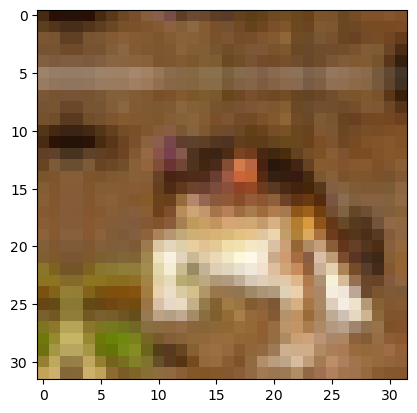

In [23]:
plt.imshow(random_translation(train_images[0]));

--- 

## Fit the model

### We will now fit some models and run some tests on the most effective augmentation techniques

We will be working with the parameters from the most accurate model from **Phase 1**:

---
- #### Model 1 - Random Zoom, Random Flip
      These augmentation techniques seem the most logical to me for this exercise, as the images will be less pixelated, as they will be scaled correctly. This also leaves an opportunity for random zoom and flip to pick up on important parts of the model. 
---

- #### Model 2 - Adding Random Rotation.
      This will test whether the first model improves when integrating random rotation.

--- 
- #### Model 3 - Adding Resize and Rescale to Model 1 (the best performing).
      This will test whether resizing and rescaling has a positive effect on mondel 1's performance.
---


### Train / Validation Split

**Firstly we will split training data into training and validation sets, setting random state to ensure consistency in data**

In [24]:
training_images, validation_images, training_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

---

## Model 1 - Random Zoom, Random Flip

In [25]:
model1 = tf.keras.Sequential([random_zoom, random_flip])

model1.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D())
model1.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D())
model1.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D())
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dense(10, activation='softmax'))

model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model1_history = model1.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=250, 
    validation_data=(validation_images, validation_labels))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.2583 - loss: 1.9638 - val_accuracy: 0.4172 - val_loss: 1.5668
Epoch 2/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.4334 - loss: 1.5535 - val_accuracy: 0.4599 - val_loss: 1.4606
Epoch 3/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4885 - loss: 1.4254 - val_accuracy: 0.4842 - val_loss: 1.4301
Epoch 4/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5183 - loss: 1.3480 - val_accuracy: 0.5202 - val_loss: 1.3348
Epoch 5/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5325 - loss: 1.3059 - val_accuracy: 0.5568 - val_loss: 1.2338
Epoch 6/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5525 - loss: 1.2599 - val_accuracy: 0.5599 - val_loss: 1.2153
Epoch 7/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5711 - loss: 1.2086 - val_accuracy: 0.5645 - val_loss: 1.2213
Epoch 8/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5827 - los

**The model does not seem to overtrain, and after 250 epochs, the accuracy and loss metrics continue to improve. This could be something to revisit, should this be the most effective model**


In [26]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   4285.290307044983  seconds


In [27]:
test_loss, test_acc = model1.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 3ms/step - accuracy: 0.7214 - loss: 0.8433

Test accuracy: 0.7214000225067139


**The model performs very well on the test set. 72% accuracy is a good score, and has added over 5% accuracy to our model. There is, however, still room for improvement, and we will add some more Data Augmentation methods to the data for model 2**

In [28]:
probability_model1 = tf.keras.Sequential([model1, 
                                         tf.keras.layers.Softmax()])

In [29]:
predictions1 = probability_model1.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


**The following two functions were provided in the curriculum to be able to plot the predicted images with their predicted labels and true ones**

In [30]:
#this function was provided in the 
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(clean[predicted_label],
                                100*np.max(predictions_array),
                                clean[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

**View model performance on one instance**

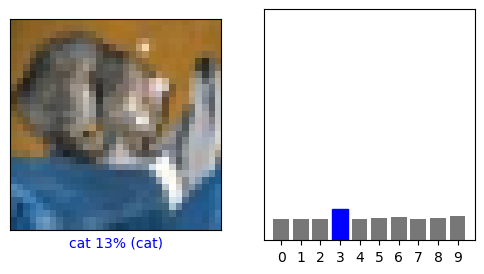

In [31]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions1[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions1[i],  test_labels)
plt.show()

**The model has accurately predicted the a cat appears in the image. The distribution, however is still not as promising as one would like with this example. We will check a larger array of the images to see if the precision is higher.**

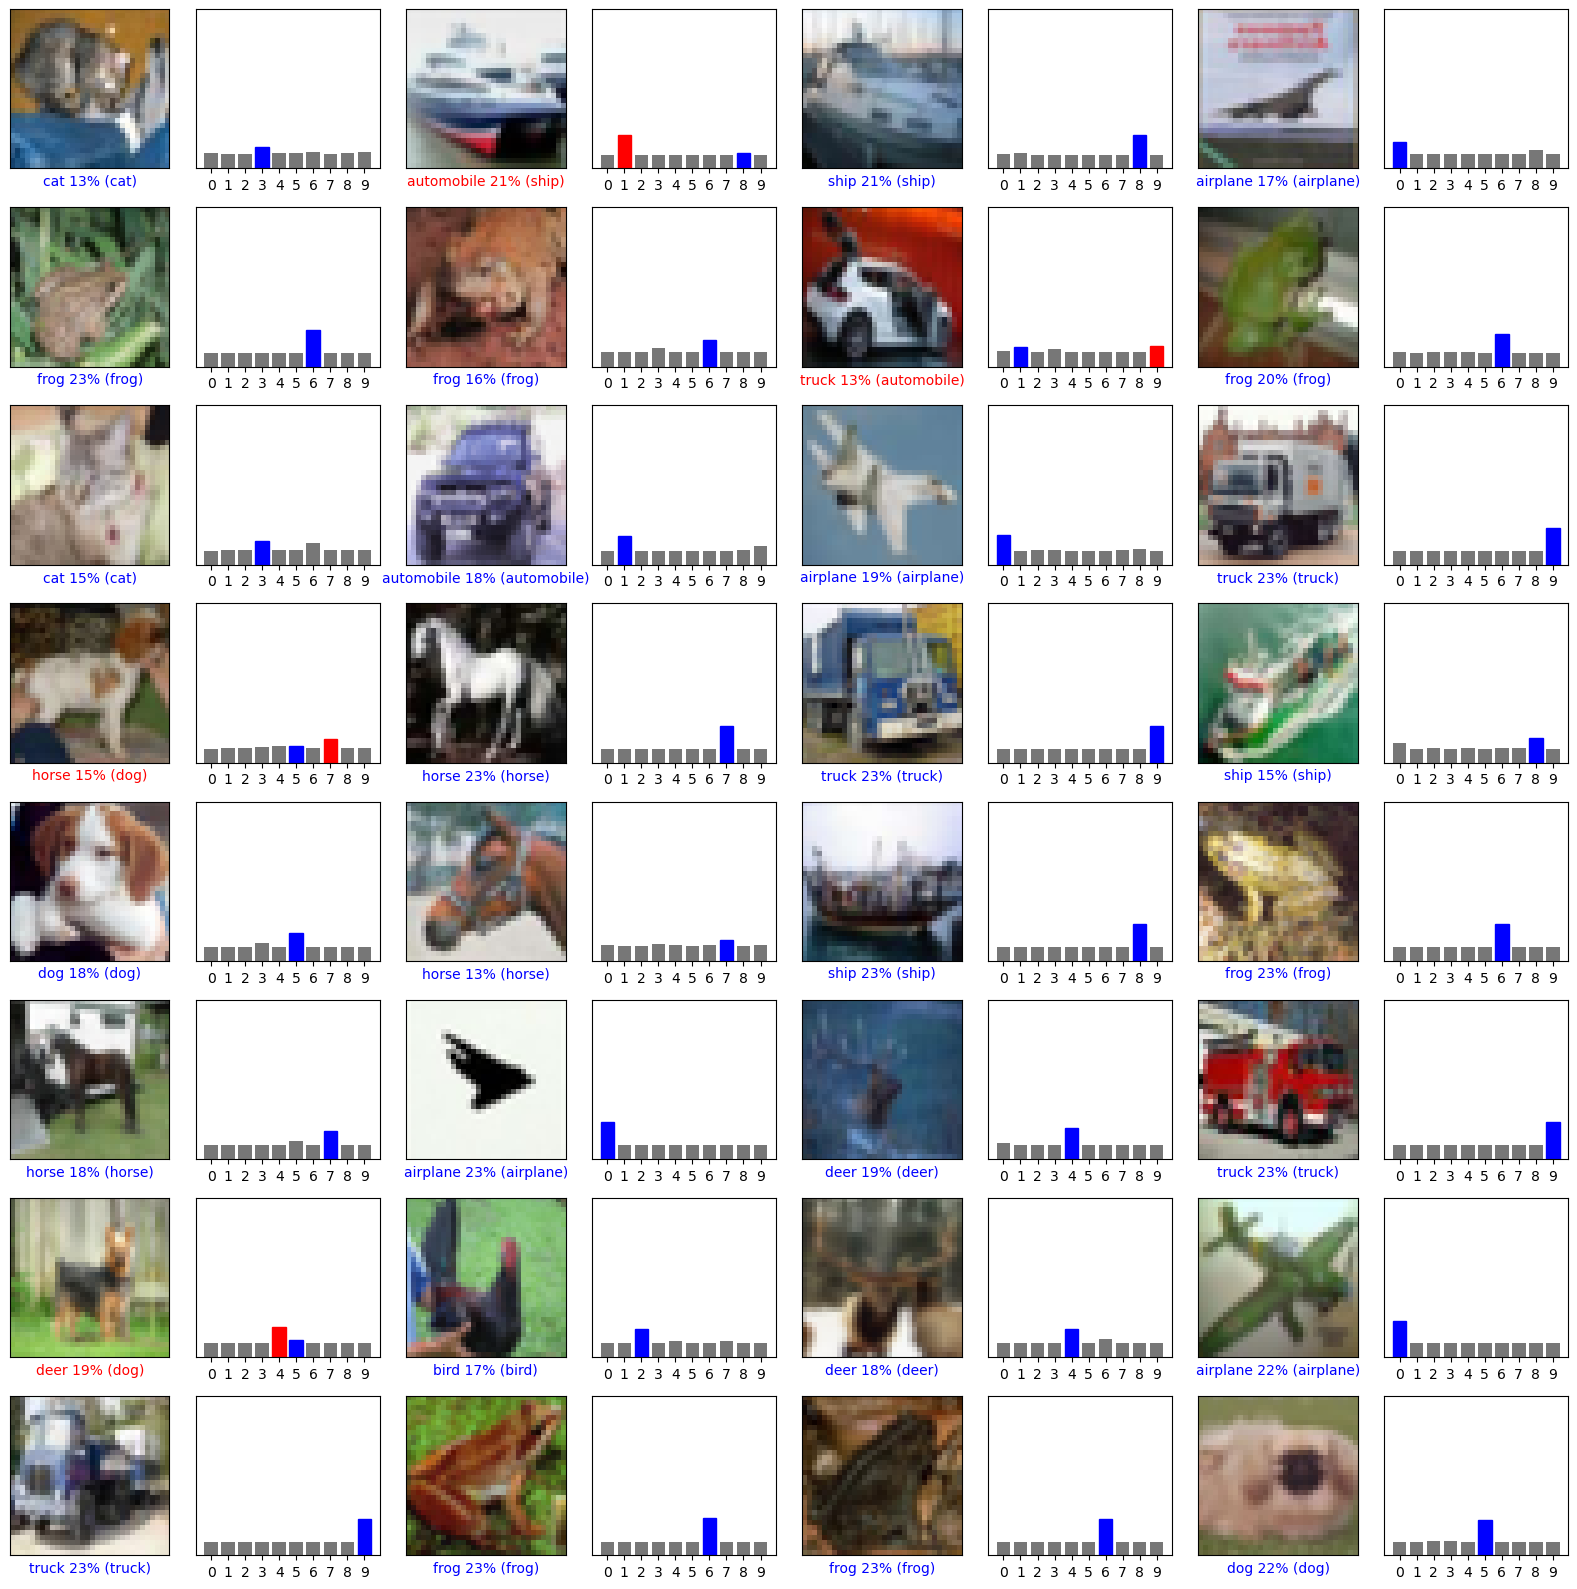

In [32]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions1[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions1[i], test_labels)
plt.tight_layout()
plt.show()

**The model is predicting much more accurately, we can see that when it makes a decision on the probability of the object contained within the image, it is predicting much more precisely, except for certain instances (deer & dog, bird & horse)**

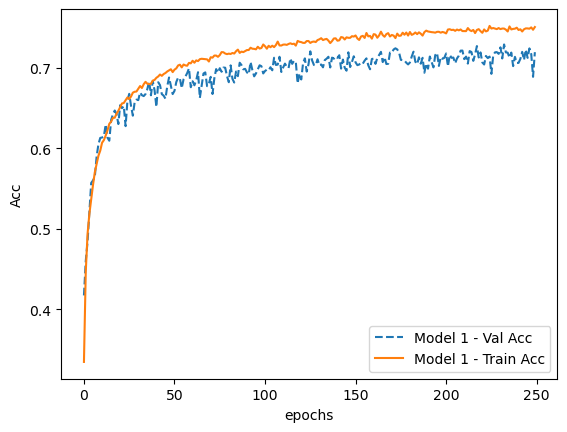

In [33]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**We can see that this model does not easily overfit, suggesting that the pooling promotes robustness, while the number of epochs can steadily improve performance.**

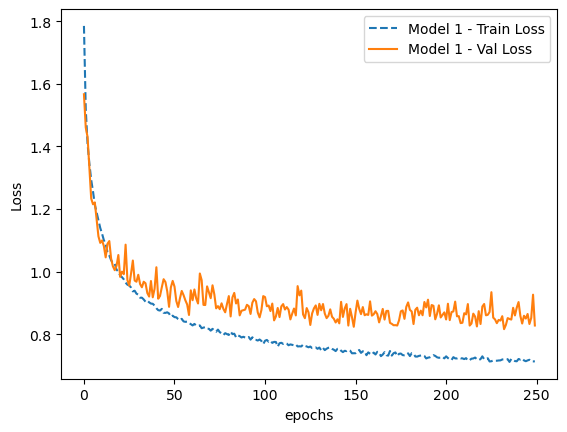

In [34]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend();

**The Loss metric on the validation set seems to be reaching its optimal level, but not overfitting. Once the optimal augmentation approach is found, we will see if it is the same. In which case, we may push for a higher number of epochs with early stopping** 

---

## Model 2 - Random Zoom, Random Flip, Random Rotation

In [55]:
model2 = tf.keras.Sequential([random_zoom, random_flip, random_rotation])

model2.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())
model2.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())
model2.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model2_history = model2.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=250, 
    validation_data=(validation_images, validation_labels))

Epoch 1/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.2318 - loss: 2.0421 - val_accuracy: 0.3441 - val_loss: 1.7872
Epoch 2/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3571 - loss: 1.7728 - val_accuracy: 0.3950 - val_loss: 1.6494
Epoch 3/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3946 - loss: 1.6646 - val_accuracy: 0.3746 - val_loss: 1.8164
Epoch 4/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4182 - loss: 1.6035 - val_accuracy: 0.4472 - val_loss: 1.5263
Epoch 5/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4391 - loss: 1.5538 - val_accuracy: 0.4513 - val_loss: 1.5310
Epoch 6/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4479 - loss: 1.5332 - val_accuracy: 0.4600 - val_loss: 1.5416
Epoch 7/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4594 - loss: 1.4997 - val_accuracy: 0.4636 - val_loss: 1.5226
Epoch 8/250
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 

KeyboardInterrupt: 

**The model does not seem to overtrain, and after 250 epochs, the accuracy and loss metrics continue to improve. This could be something to revisit, should this be the most effective model**


In [36]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   8947.845783948898  seconds


In [37]:
test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 4ms/step - accuracy: 0.5850 - loss: 1.2097

Test accuracy: 0.5849999785423279


**The model performs very well on the test set. 72% accuracy is a good score, and has added over 5% accuracy to our model. There is, however, still room for improvement, and we will add some more Data Augmentation methods to the data for model 2**

In [38]:
probability_model2 = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

In [39]:
predictions2 = probability_model2.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


**View model performance on one instance**

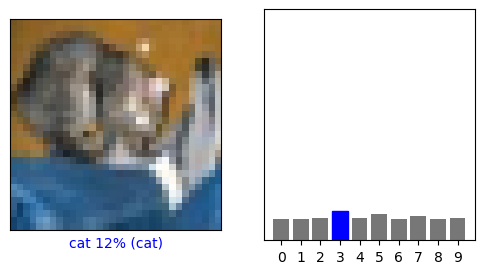

In [40]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions2[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions2[i],  test_labels)
plt.show()

**The model has accurately predicted the a cat appears in the image. The distribution, however is still not as promising as one would like with this example. We will check a larger array of the images to see if the precision is higher.**

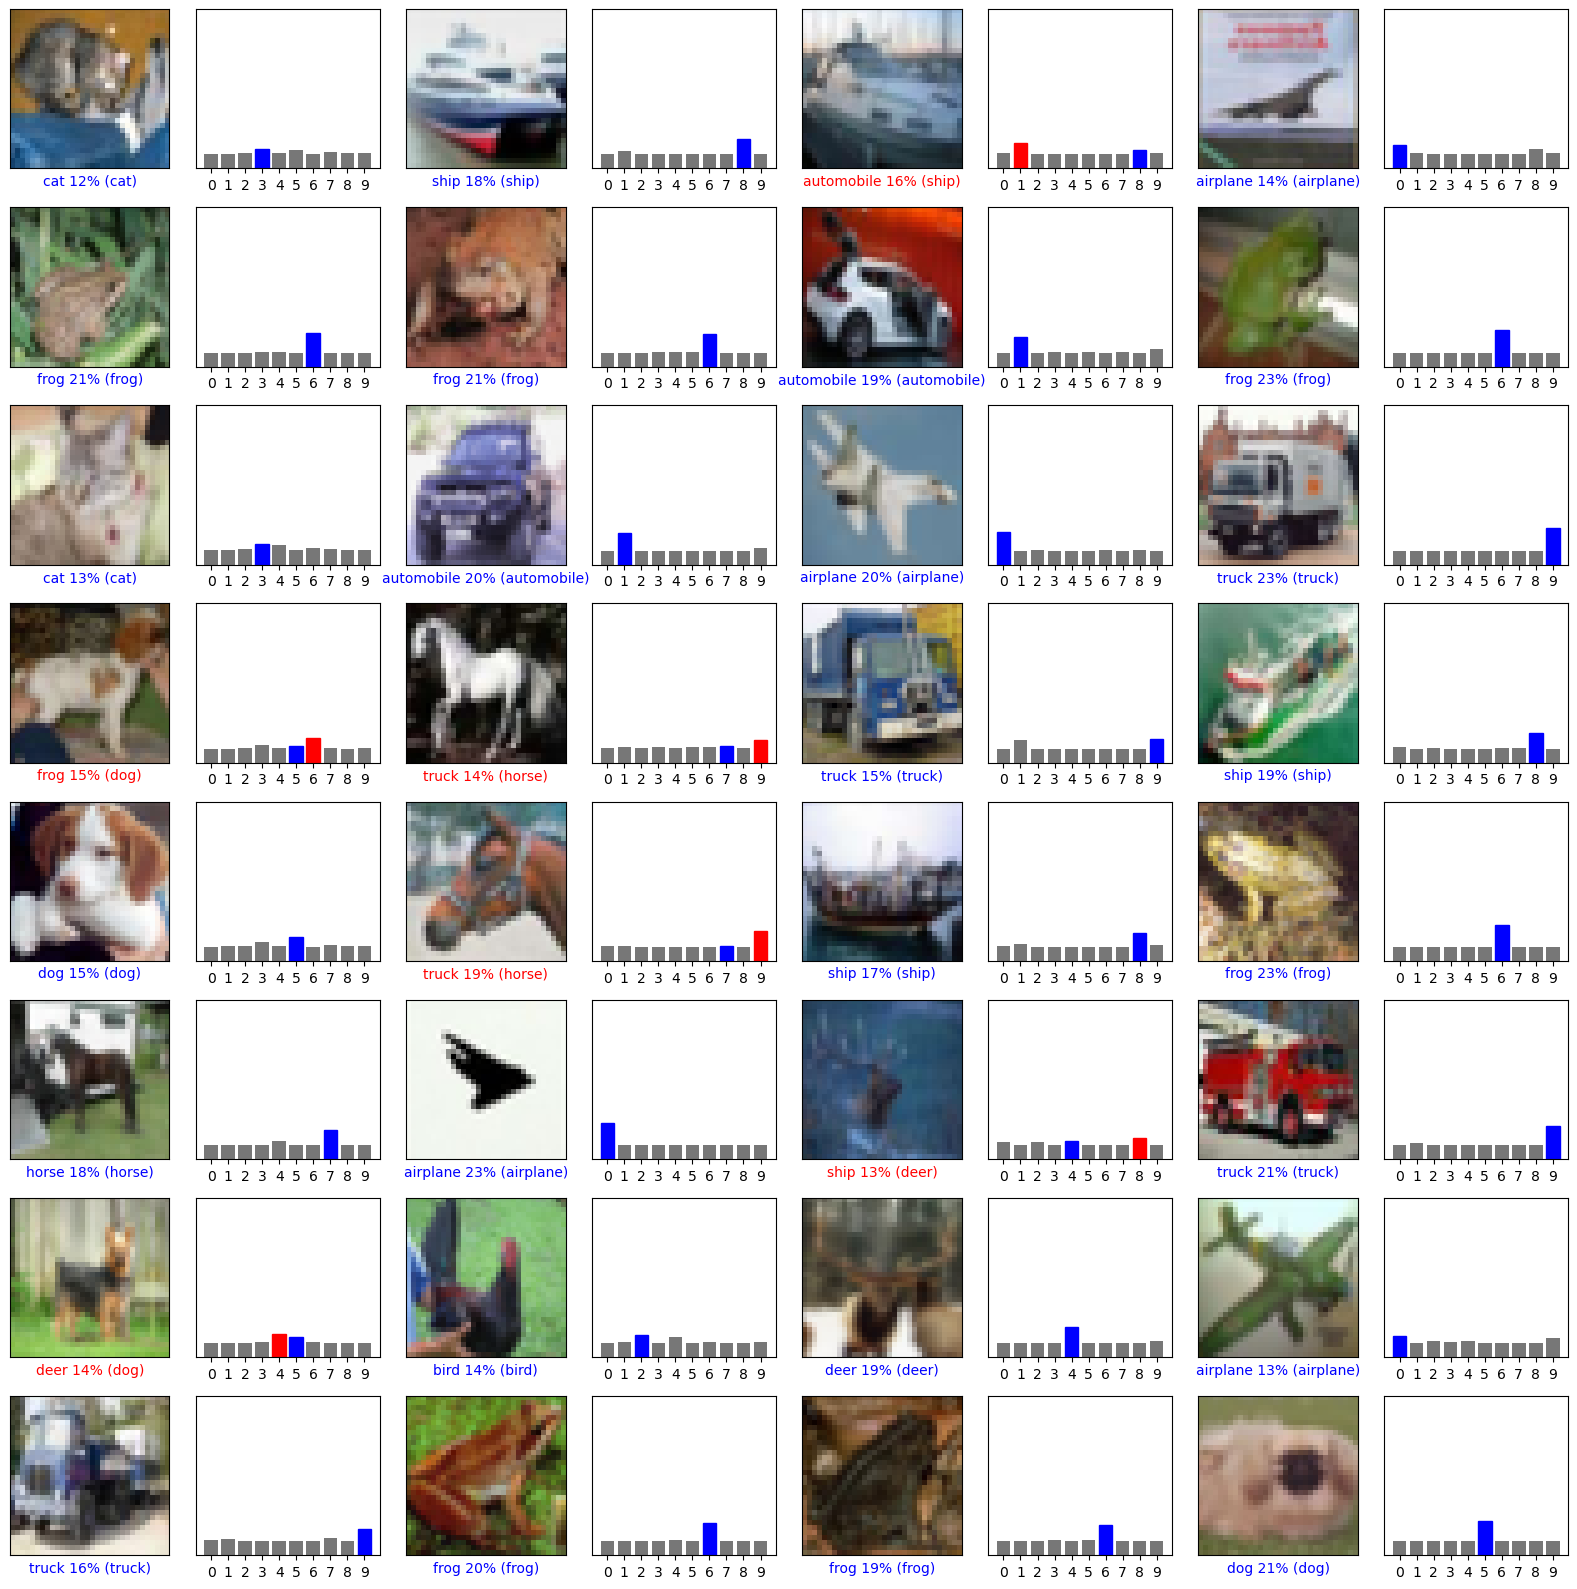

In [41]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions2[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions2[i], test_labels)
plt.tight_layout()
plt.show()

**The model is predicting much more accurately, we can see that when it makes a decision on the probability of the object contained within the image, it is predicting much more precisely, except for certain instances (deer & dog, bird & horse)**

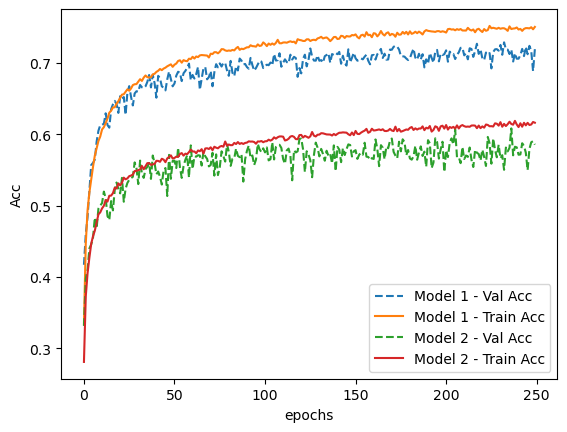

In [42]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")

plt.plot(model2_history.history['val_accuracy'], '--', label="Model 2 - Val Acc")
plt.plot(model2_history.history['accuracy'], label="Model 2 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**We can see that this model does not easily overfit, suggesting that the pooling promotes robustness, while the number of epochs can steadily improve performance.**

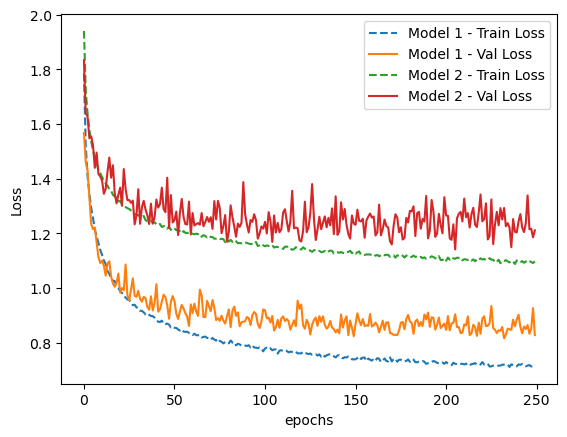

In [43]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.plot(model2_history.history['loss'], '--', label="Model 2 - Train Loss")
plt.plot(model2_history.history['val_loss'], label="Model 2 - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend();

**The Loss metric on the validation set seems to be reaching its optimal level, but not overfitting. Once the optimal augmentation approach is found, we will see if it is the same. In which case, we may push for a higher number of epochs with early stopping** 

---

## Model 3 - Adding Resizing and Rescaling to Random_Zoom and Random Flip

In [44]:
model3 = tf.keras.Sequential([tf.keras.layers.Resizing(255, 255),tf.keras.layers.Rescaling(1),random_zoom, random_flip])

model3.add(tf.keras.layers.Conv2D(16, (3,3), input_shape=(32,32,3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D())
model3.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D())
model3.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D())

model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model3_history = model3.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=150, 
    validation_data=(validation_images, validation_labels))

Epoch 1/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 627s 500ms/step - accuracy: 0.2919 - loss: 1.9405 - val_accuracy: 0.4567 - val_loss: 1.5066
Epoch 2/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 732s 586ms/step - accuracy: 0.4531 - loss: 1.5204 - val_accuracy: 0.4915 - val_loss: 1.4107
Epoch 3/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 577s 461ms/step - accuracy: 0.4935 - loss: 1.4092 - val_accuracy: 0.5056 - val_loss: 1.3753
Epoch 4/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 589s 471ms/step - accuracy: 0.5126 - loss: 1.3561 - val_accuracy: 0.5300 - val_loss: 1.3369
Epoch 5/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 724s 579ms/step - accuracy: 0.5316 - loss: 1.3088 - val_accuracy: 0.5429 - val_loss: 1.2718
Epoch 6/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 785s 628ms/step - accuracy: 0.5461 - loss: 1.2739 - val_accuracy: 0.5066 - val_loss: 1.4031
Epoch 7/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 800s 640ms/step - accuracy: 0.5586 - loss: 1.2544 - val_accuracy: 0.5713 - val_loss: 1.2042
Epoch 8/150
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 695s 556ms/s

**The model does not seem to overtrain at first, although it does begin to plateau around 60 epochs.**


In [45]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   113494.91630387306  seconds


In [46]:
test_loss, test_acc = model3.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 36s - 114ms/step - accuracy: 0.6334 - loss: 1.2542

Test accuracy: 0.633400022983551


**The model performs well on the test set, however the 72% accuracy achieved in the first model outlines that the time and resources taken to resize and rescale actually hinder the model's performance**

In [47]:
probability_model3 = tf.keras.Sequential([model3, 
                                         tf.keras.layers.Softmax()])

In [48]:
predictions3 = probability_model3.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step


**View model performance on one instance**

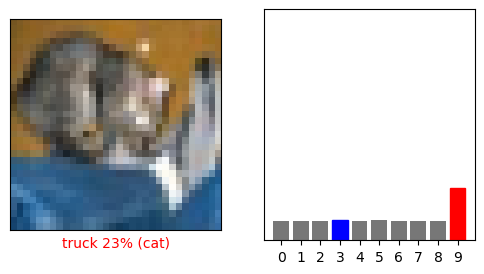

In [49]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions3[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions3[i],  test_labels)
plt.show()

**The model has inaccurately predicted the a cat appears in the image. The distribution is much better, however the augmentation of data may cause the shapes in images to be poorly represented. We will investigate this, reviewing the model with more instances.**

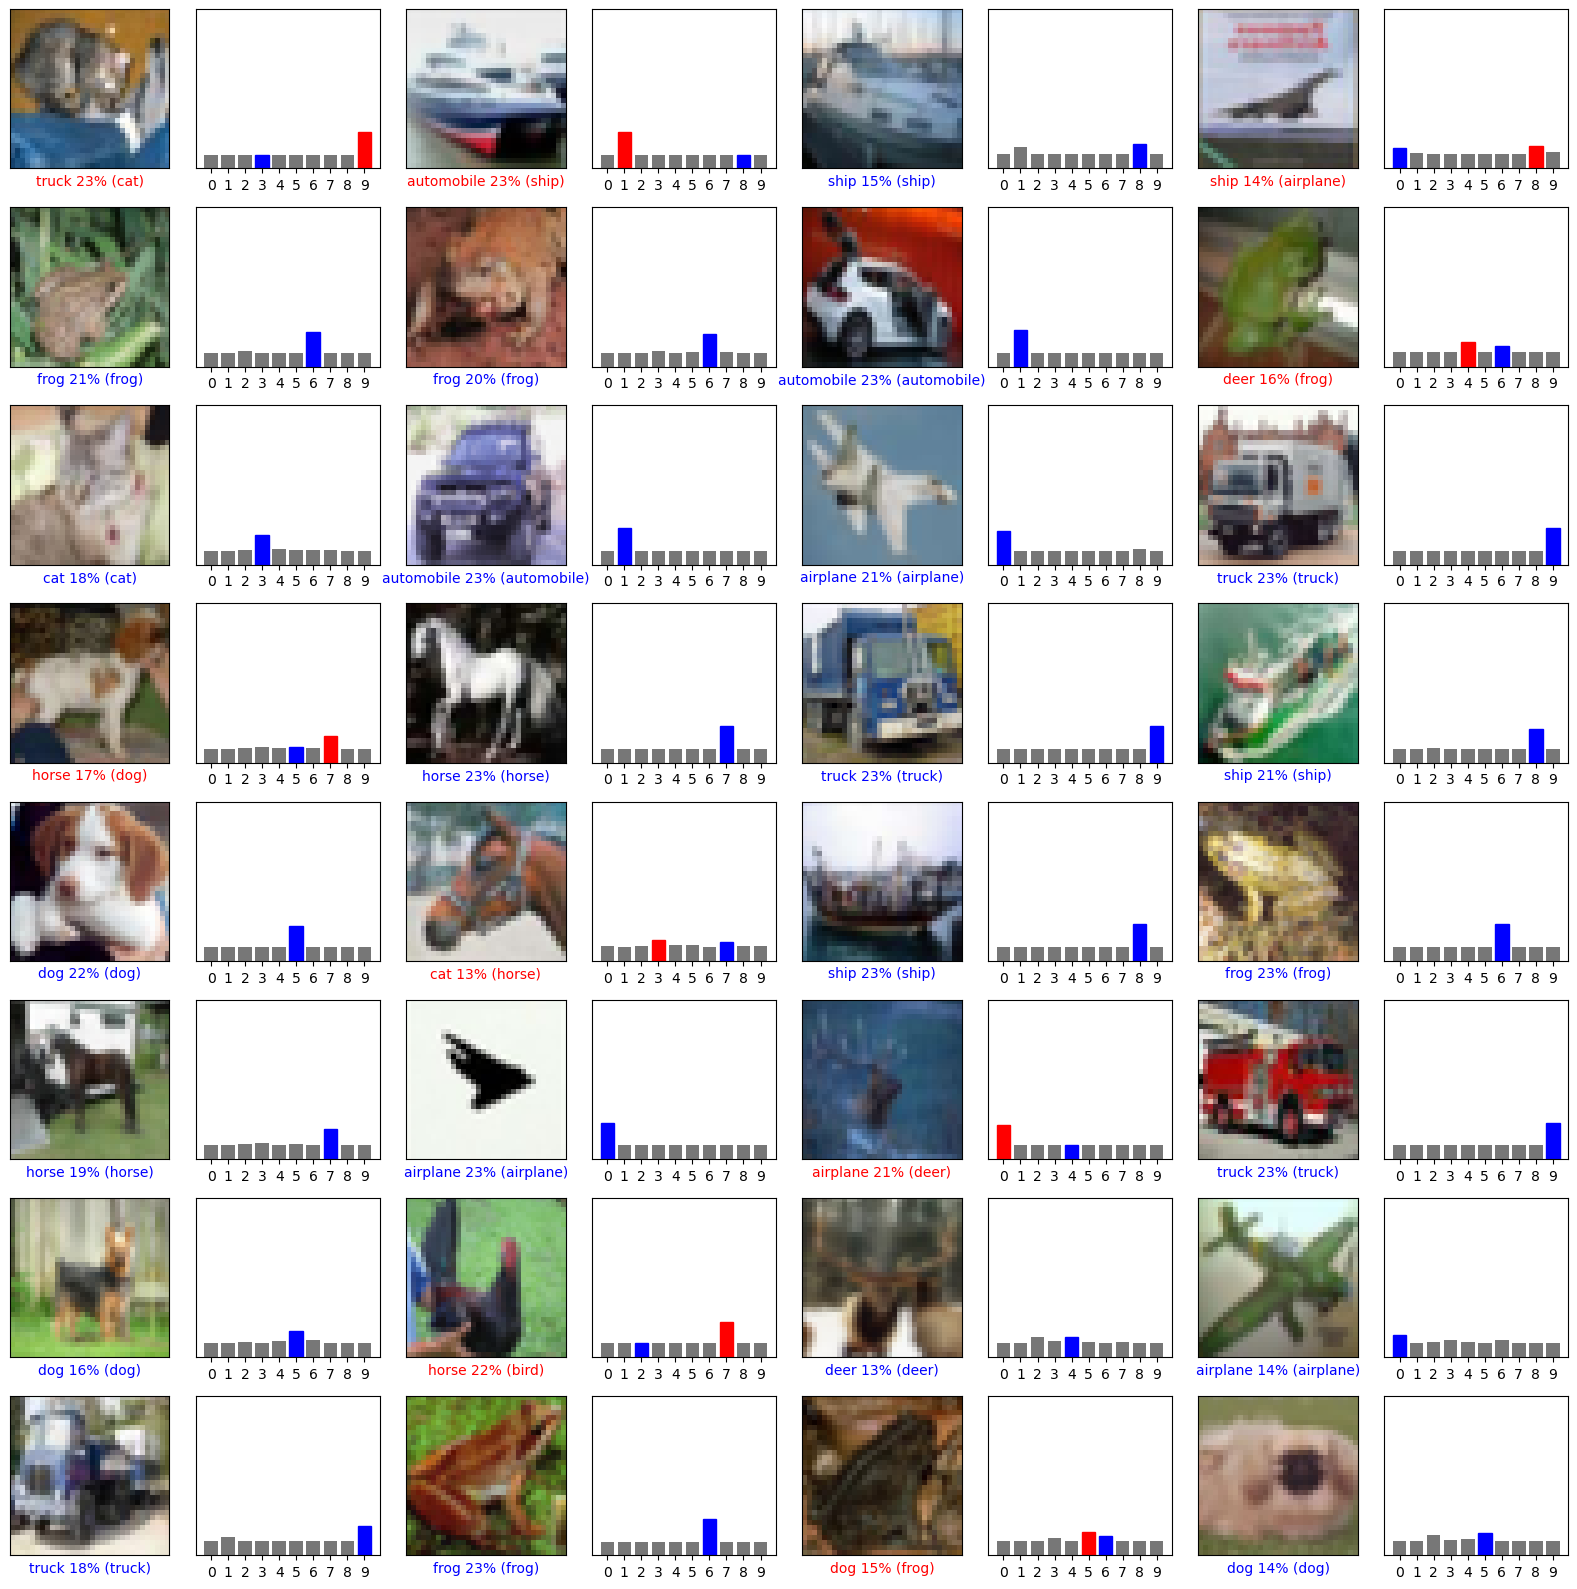

In [50]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions3[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions3[i], test_labels)
plt.tight_layout()
plt.show()

**The model is predicting relatively accurately, we can see that when it makes a decision on the probability of the object contained within the image, it is predicting much more precisely. Although it is the same for when it is wrong.**

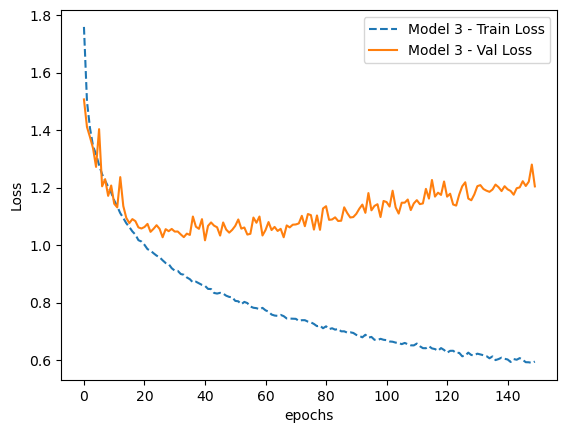

In [51]:
plt.plot(model3_history.history['loss'], '--', label="Model 3 - Train Loss")
plt.plot(model3_history.history['val_loss'], label="Model 3 - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

**Model performance seems to deteriate aound the 40th epoch, with loss beginning to increase consitantly**

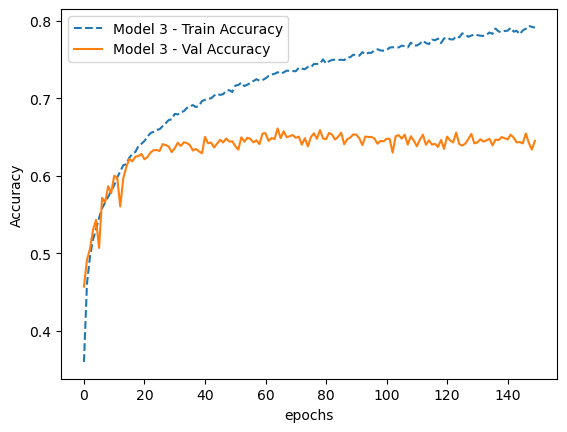

In [52]:
plt.plot(model3_history.history['accuracy'], '--', label="Model 3 - Train Accuracy")
plt.plot(model3_history.history['val_accuracy'], label="Model 3 - Val Accuracy")

plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

**The training accuracy increases, while the validation accuracy plateaus, suggesting overtraining.**

 ---

## Comparing Model 1, Model 2 and Model 3

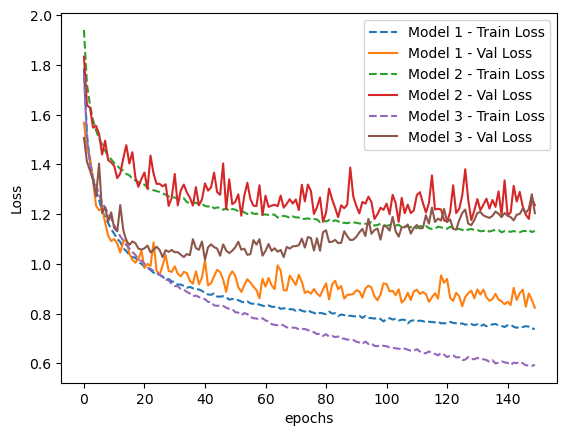

In [53]:
plt.plot(model1_history.history['loss'][:150], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'][:150], label="Model 1 - Val Loss")

plt.plot(model2_history.history['loss'][:150], '--', label="Model 2 - Train Loss")
plt.plot(model2_history.history['val_loss'][:150], label="Model 2 - Val Loss")

plt.plot(model3_history.history['loss'], '--', label="Model 3 - Train Loss")
plt.plot(model3_history.history['val_loss'], label="Model 3 - Val Loss")


plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

**While Model 3's loss metrics outperform those of model 2 (including random rotation), it still seems that random zoom and flip are the truest augmentation methods to training the model and retaining a representation of the image fed into the model**

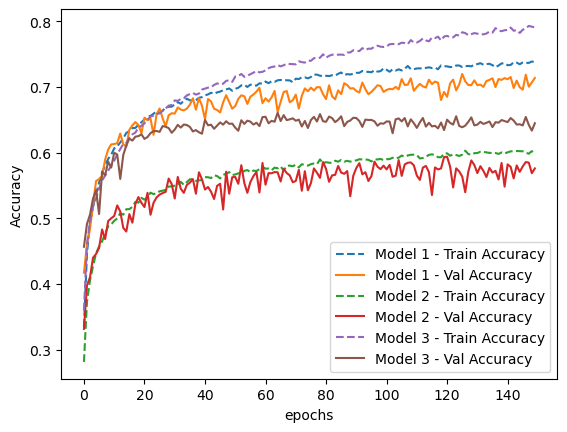

In [54]:
plt.plot(model1_history.history['accuracy'][:150], '--', label="Model 1 - Train Accuracy")
plt.plot(model1_history.history['val_accuracy'][:150], label="Model 1 - Val Accuracy")

plt.plot(model2_history.history['accuracy'][:150], '--', label="Model 2 - Train Accuracy")
plt.plot(model2_history.history['val_accuracy'][:150], label="Model 2 - Val Accuracy")

plt.plot(model3_history.history['accuracy'], '--', label="Model 3 - Train Accuracy")
plt.plot(model3_history.history['val_accuracy'], label="Model 3 - Val Accuracy")

plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

**Once again, the model performances suggest that Model 1 performs the best with the data, and a simple zoom and flip augmentation proving the most robust.**

---

## Conclusion

The most effective model was the first, achieving a 72% accuracy score, while limiting loss. 

In **Phase 3** we will explore improving upon the model by

- Increasing the epochs to 500 to see the potential
- Testing regularizers to find the best model.
- Seeing if experimenting with Neurons in Convolutional Layers can boost the model. 